In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from scipy import linalg
from tensorly.base import unfold
from tensorly.decomposition import tucker

import tensor_utils as utils

np.random.seed(14159)

In [2]:
# Parameters
d = 3
n = np.array([100, 200, 300])
r = np.array([3, 4, 5])
frobH = 3

N = np.sum(n)
c = n/N
setting = "$\\mathbf{{n}} = {{{}}}^\\top \\quad \\mathbf{{r}} = {{{}}}^\\top \\quad ||\\mathbf{{H}}||_F = {{{}}}$".format(list(n), list(r), frobH)

print("Phase transition position : {}".format(np.sqrt(np.prod(c)*(N**(d-2)))))

Phase transition position : 4.0824829046386295


In [3]:
# Model
H = np.random.randn(*r)
H = frobH*H/utils.frob(H)
X = [linalg.orth(np.random.randn(n[j], r[j])) for j in range(d)]
Z = np.random.randn(*n)
P = utils.tucker_prod(H, X)
T = P+Z/np.sqrt(N)
# G, U = tucker(T, r, verbose=True)

In [4]:
P_unfold = [unfold(P, i) for i in range(d)]
T_unfold = [unfold(T, i) for i in range(d)]
Xt = [linalg.eigh(P_unfold[i]@P_unfold[i].T)[1][:, -r[i]:] for i in range(d)]

# Tucker ALS

In [5]:
# Initialization
delta = 1e-4
U_ite = [[linalg.eigh(T_unfold[i]@T_unfold[i].T)[1][:, -r[i]:] for i in range(d)]]
kron_prod = reduce(np.kron, U_ite[0][1:])
G_ite = [U_ite[0][0].T@T_unfold[0]@kron_prod]
T_approx = [U_ite[0][0]@G_ite[0]@kron_prod.T]
diff_approx = [np.sum((T_unfold[0]-T_approx[0])**2)]
norm_p, norm_m = np.sum(G_ite[0]**2), np.nan

In [6]:
# Loop
ite = 1
stop = False
diff_norm = []
while not stop:
    kron_prods = [reduce(np.kron, U_ite[ite-1][:i]+U_ite[ite-1][i+1:]) for i in range(d)]
    U_ite.append([linalg.svd(T_unfold[i]@kron_prods[i])[0][:, :r[i]] for i in range(d)])
    G_ite.append(U_ite[ite][0].T@T_unfold[0]@kron_prods[0])
    T_approx.append(U_ite[ite][0]@G_ite[ite]@kron_prods[0].T)
    diff_approx.append(np.sum((T_unfold[0]-T_approx[ite])**2))
    norm_p, norm_m = np.sum(G_ite[ite]**2), norm_p
    diff_norm.append(np.abs(norm_p-norm_m))
    print("{:e}".format(diff_norm[ite-1]), end='\r', flush=True)
    stop = (diff_norm[ite-1] < delta)
    ite += 1

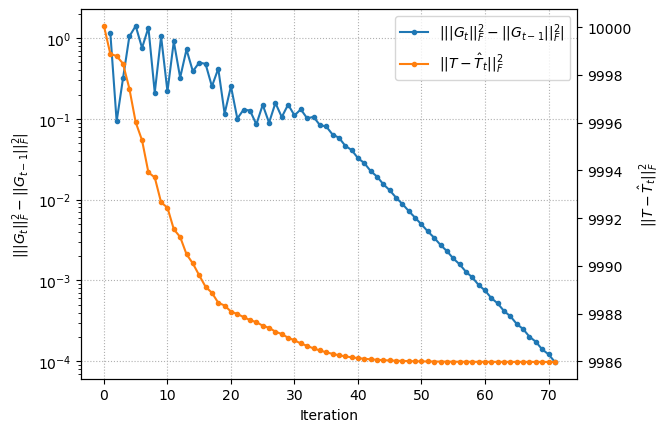

In [7]:
fig = plt.figure()
ax1 = fig.gca()
ax2 = ax1.twinx()
plot1 = ax1.plot(np.arange(1, ite), diff_norm, marker='.', color='C0')
plot2 = ax2.plot(np.arange(ite), diff_approx, marker='.', color='C1')
ax1.set_yscale('log')
ax1.grid(ls=':')
ax1.set_ylabel("$| || G_t ||_F^2 - || G_{t-1} ||_F^2 |$")
ax2.set_ylabel("$|| T - \\hat{T}_t ||_F^2$")
ax1.set_xlabel("Iteration")
ax1.legend(plot1+plot2, ["$| || G_t ||_F^2 - || G_{t-1} ||_F^2 |$", "$|| T - \\hat{T}_t ||_F^2$"]);

# Alignments

In [8]:
alignments = [[np.sort(np.max((Xt[i].T@U[i])**2, axis=0)) for i in range(d)] for U in U_ite]

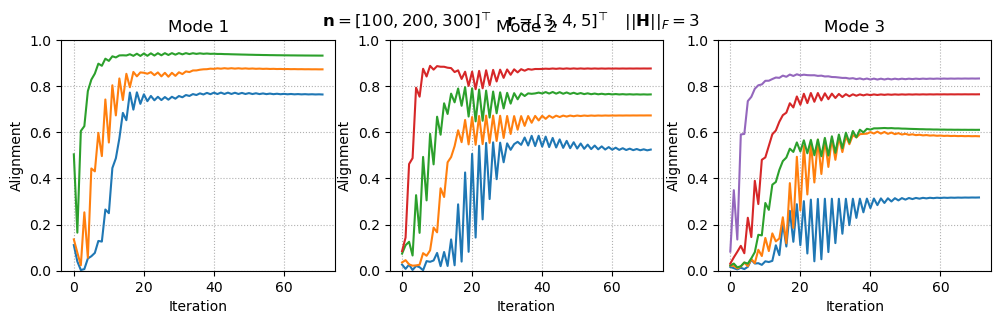

In [9]:
fig, ax = plt.subplots(1, d, figsize=(d*4, 3))
for i in range(d):
    ax[i].plot([alignments[j][i] for j in range(ite)])
    ax[i].grid(ls=':')
    ax[i].set_ylim(0, 1)
    ax[i].set_xlabel("Iteration")
    ax[i].set_ylabel("Alignment")
    ax[i].set_title("Mode {}".format(i+1))
fig.suptitle(setting);